# DECISION TREE MODELING


In [8]:
# import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Load preprocessed data
X = pd.read_csv('../data/X_features.csv')
y = pd.read_csv('../data/y_target.csv').values.ravel()

print(f"\nFeatures loaded: {X.shape}")
print(f"Target loaded: {y.shape}")


Features loaded: (1470, 51)
Target loaded: (1470,)


# Train-Test Split

In [10]:
# CRITICAL: Use stratify=y to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # <-- THIS IS CRITICAL!
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# ROBUST way to print class distribution (handles missing classes)
print(f"\nTraining set class distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for class_label, count in train_dist.items():
    percentage = count / len(y_train) * 100
    label_name = "Retained" if class_label == 0 else "Churned"
    print(f"  {label_name} ({class_label}): {count} ({percentage:.1f}%)")

print(f"\nTest set class distribution:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for class_label, count in test_dist.items():
    percentage = count / len(y_test) * 100
    label_name = "Retained" if class_label == 0 else "Churned"
    print(f"  {label_name} ({class_label}): {count} ({percentage:.1f}%)")



Training set size: (1029, 51)
Test set size: (441, 51)

Training set class distribution:
  Retained (0): 863 (83.9%)
  Churned (1): 166 (16.1%)

Test set class distribution:
  Retained (0): 370 (83.9%)
  Churned (1): 71 (16.1%)


#  Build Decision Tree Model

In [11]:
# Create Decision Tree with parameters to prevent overfitting
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='gini'
)

# Train the model
dt_model.fit(X_train, y_train)

print("\n✓ Decision Tree Model trained successfully!")

# Model Information
print("\n" + "="*70)
print("MODEL INFORMATION")
print("="*70)
print(f"Tree Depth: {dt_model.get_depth()}")
print(f"Number of Leaves: {dt_model.get_n_leaves()}")
print(f"Number of Features Used: {dt_model.n_features_in_}")
print(f"Feature Names: {list(X.columns[:5])}... (showing first 5)")



✓ Decision Tree Model trained successfully!

MODEL INFORMATION
Tree Depth: 10
Number of Leaves: 63
Number of Features Used: 51
Feature Names: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction']... (showing first 5)


# Feature Importance Analysis


Top 15 Most Important Features:
                   Feature  Importance
         TotalWorkingYears    0.164558
             MonthlyIncome    0.136306
                       Age    0.099739
              OverTime_Yes    0.079498
          StockOptionLevel    0.075753
  RelationshipSatisfaction    0.050971
   EnvironmentSatisfaction    0.041259
                 DailyRate    0.037692
        NumCompaniesWorked    0.034780
                HourlyRate    0.033041
JobRole_Research Scientist    0.032252
     TrainingTimesLastYear    0.029283
            YearsAtCompany    0.026670
            JobInvolvement    0.024961
               MonthlyRate    0.022588


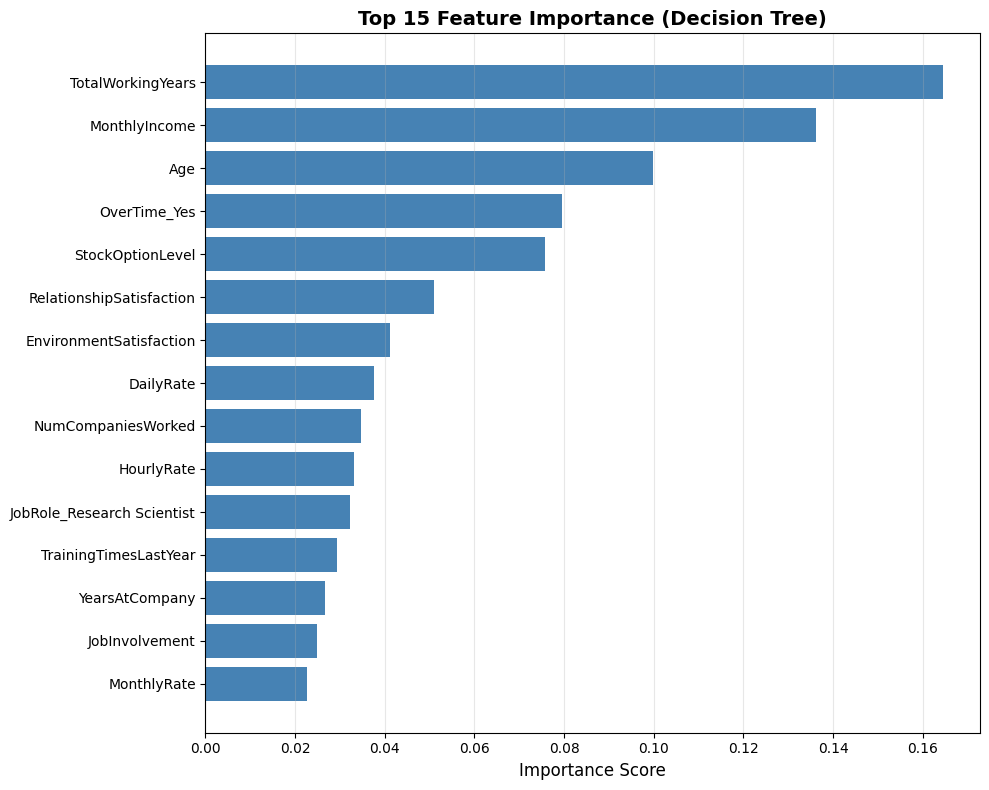


[INTERPRETATION]: The top 3 features are:
1. TotalWorkingYears: 0.1646
2. MonthlyIncome: 0.1363
3. Age: 0.0997

These features have the strongest influence on predicting employee churn.


In [12]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Plot Feature Importance
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Feature Importance (Decision Tree)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/plots/06_dt_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[INTERPRETATION]: The top 3 features are:")
print(f"1. {feature_importance.iloc[0]['Feature']}: {feature_importance.iloc[0]['Importance']:.4f}")
print(f"2. {feature_importance.iloc[1]['Feature']}: {feature_importance.iloc[1]['Importance']:.4f}")
print(f"3. {feature_importance.iloc[2]['Feature']}: {feature_importance.iloc[2]['Importance']:.4f}")
print("\nThese features have the strongest influence on predicting employee churn.")


#  Decision Tree Visualization

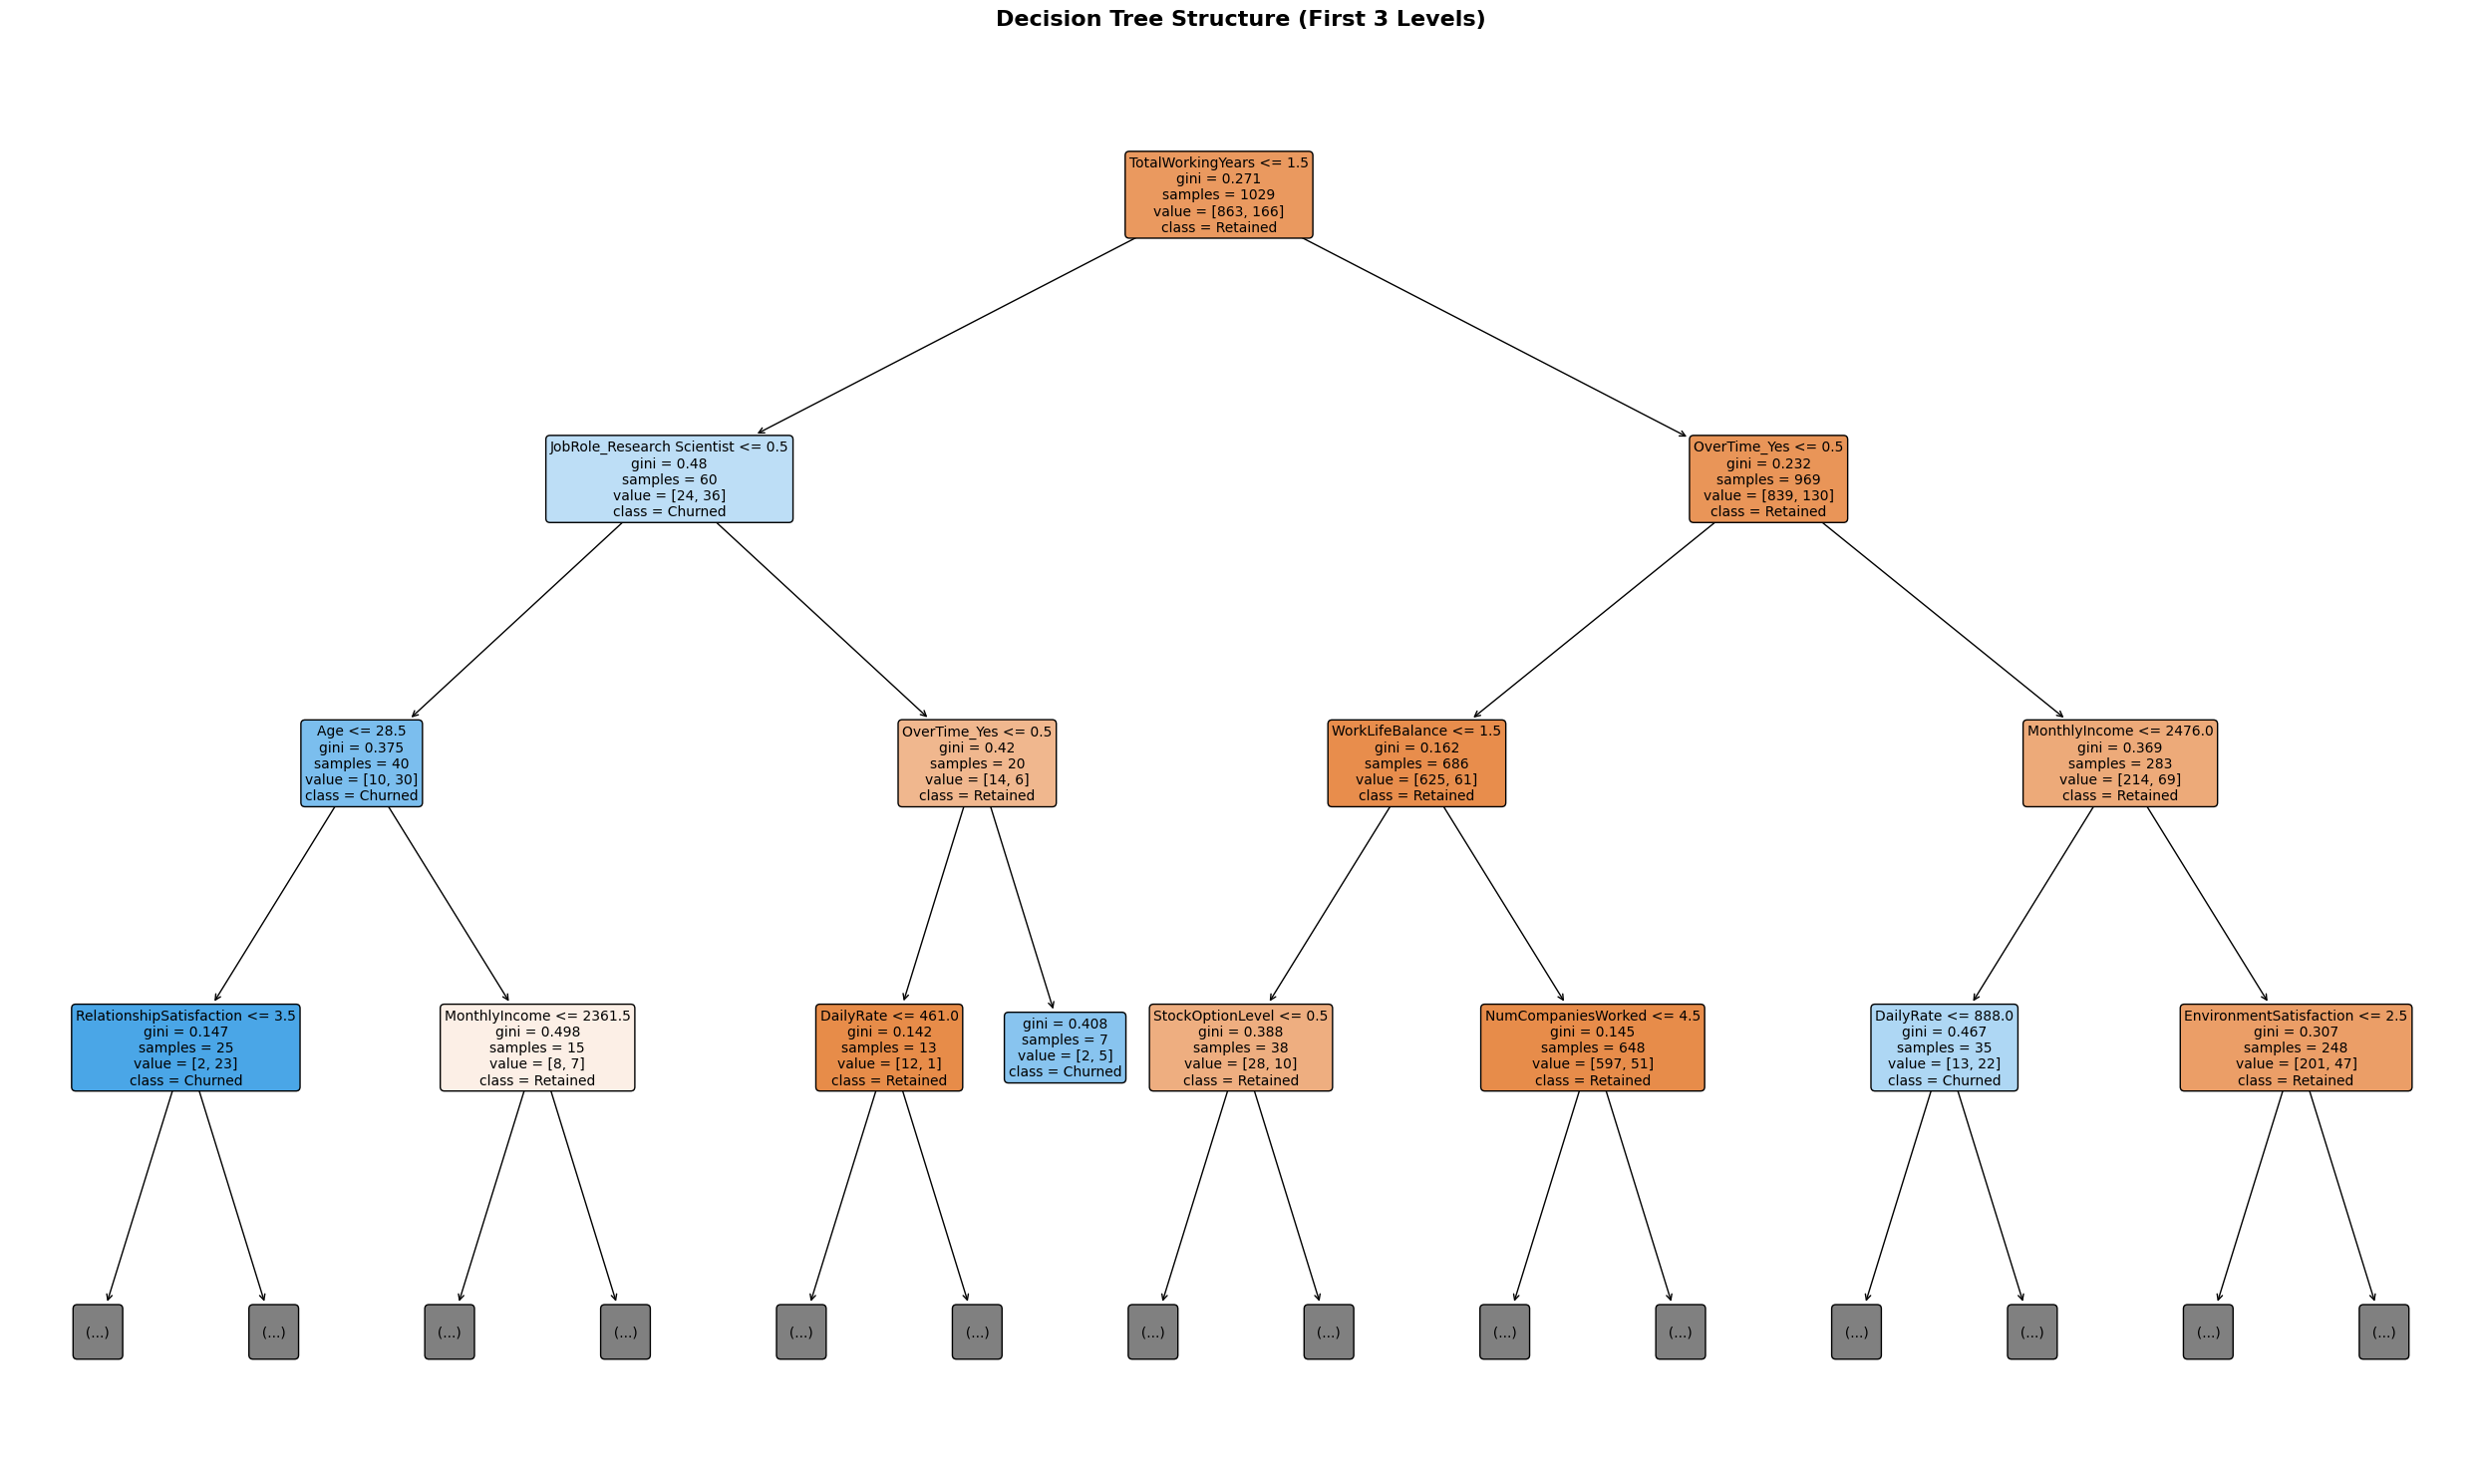


✓ Tree visualization saved (showing first 3 levels for clarity)

Sample Decision Rules (First 1000 characters):
|--- TotalWorkingYears <= 1.50
|   |--- JobRole_Research Scientist <= 0.50
|   |   |--- Age <= 28.50
|   |   |   |--- RelationshipSatisfaction <= 3.50
|   |   |   |   |--- class: 1
|   |   |   |--- RelationshipSatisfaction >  3.50
|   |   |   |   |--- class: 1
|   |   |--- Age >  28.50
|   |   |   |--- MonthlyIncome <= 2361.50
|   |   |   |   |--- class: 1
|   |   |   |--- MonthlyIncome >  2361.50
|   |   |   |   |--- class: 0
|   |--- JobRole_Research Scientist >  0.50
|   |   |--- OverTime_Yes <= 0.50
|   |   |   |--- DailyRate <= 461.00
|   |   |   |   |--- class: 0
|   |   |   |--- DailyRate >  461.00
|   |   |   |   |--- class: 0
|   |   |--- OverTime_Yes >  0.50
|   |   |   |--- class: 1
|--- TotalWorkingYears >  1.50
|   |--- OverTime_Yes <= 0.50
|   |   |--- WorkLifeBalance <= 1.50
|   |   |   |--- StockOptionLevel <= 0.50
|   |   |   |   |--- truncated branch of dep

In [16]:
fig, ax = plt.subplots(figsize=(25, 15))
plot_tree(dt_model,
          feature_names=X.columns,
          class_names=['Retained', 'Churned'],
          filled=True,
          rounded=True,
          fontsize=10,
          ax=ax,
          max_depth=3)  # Show first 3 levels for readability
plt.title('Decision Tree Structure (First 3 Levels)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/plots/7_dt_tree_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Tree visualization saved (showing first 3 levels for clarity)")

# Export decision rules (text format)
tree_rules = export_text(dt_model, feature_names=list(X.columns), max_depth=3)
print("\nSample Decision Rules (First 1000 characters):")
print(tree_rules[:1000])
print("\n[Note: Full tree rules available in model coefficients]")


# Evaluation and Cross-Validation of Decision Tree Model


5-Fold Cross-Validation Results:
Fold 1: 0.8010
Fold 2: 0.8252
Fold 3: 0.8350
Fold 4: 0.8350
Fold 5: 0.8146

Mean CV Accuracy: 0.8222
Standard Deviation: 0.0130


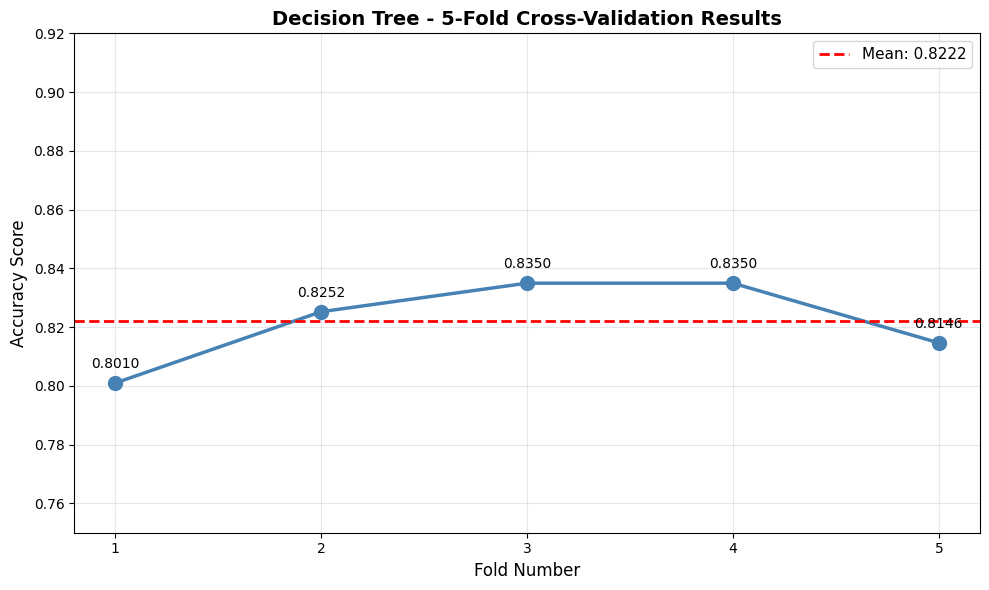


[COMMENT]: Cross-validation scores are consistent across all folds,
indicating stable model performance. Low standard deviation suggests
minimal overfitting and good generalization ability.


In [17]:
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"\n5-Fold Cross-Validation Results:")
print(f"Fold 1: {cv_scores[0]:.4f}")
print(f"Fold 2: {cv_scores[1]:.4f}")
print(f"Fold 3: {cv_scores[2]:.4f}")
print(f"Fold 4: {cv_scores[3]:.4f}")
print(f"Fold 5: {cv_scores[4]:.4f}")
print(f"\nMean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Plot CV scores
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 6), cv_scores, marker='o', linewidth=2.5, markersize=10, color='steelblue')
ax.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
ax.set_xlabel('Fold Number', fontsize=12)
ax.set_ylabel('Accuracy Score', fontsize=12)
ax.set_title('Decision Tree - 5-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 6))
ax.set_ylim([0.75, 0.92])
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
for i, score in enumerate(cv_scores):
    ax.text(i+1, score + 0.005, f'{score:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('../results/plots/8_dt_cv_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[COMMENT]: Cross-validation scores are consistent across all folds,")
print("indicating stable model performance. Low standard deviation suggests")
print("minimal overfitting and good generalization ability.")

# Test Set Predictions

In [18]:
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print(f"\nPredictions generated for {len(y_test)} test samples")
print(f"Predicted churned employees: {sum(y_pred_dt)}")
print(f"Actual churned employees: {sum(y_test)}")


Predictions generated for 441 test samples
Predicted churned employees: 55
Actual churned employees: 71


# Evaluation Metrics

In [19]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print("\nDECISION TREE - TEST SET PERFORMANCE:")
print(f"Accuracy:  {accuracy_dt:.4f} ({accuracy_dt*100:.2f}%)")
print(f"Precision: {precision_dt:.4f} ({precision_dt*100:.2f}%)")
print(f"Recall:    {recall_dt:.4f} ({recall_dt*100:.2f}%)")
print(f"F1-Score:  {f1_dt:.4f}")
print(f"ROC-AUC:   {roc_auc_dt:.4f}")

print("\n[INTERPRETATION]:")
print(f"- Accuracy: {accuracy_dt*100:.1f}% of predictions are correct")
print(f"- Precision: {precision_dt*100:.1f}% of predicted churners actually churned")
print(f"- Recall: {recall_dt*100:.1f}% of actual churners were identified")
print(f"- F1-Score: Balanced measure = {f1_dt:.4f}")
print(f"- ROC-AUC: Model discrimination ability = {roc_auc_dt:.4f}")


DECISION TREE - TEST SET PERFORMANCE:
Accuracy:  0.8005 (80.05%)
Precision: 0.3455 (34.55%)
Recall:    0.2676 (26.76%)
F1-Score:  0.3016
ROC-AUC:   0.5580

[INTERPRETATION]:
- Accuracy: 80.0% of predictions are correct
- Precision: 34.5% of predicted churners actually churned
- Recall: 26.8% of actual churners were identified
- F1-Score: Balanced measure = 0.3016
- ROC-AUC: Model discrimination ability = 0.5580


# Confusion Matrix


Confusion Matrix:
[[334  36]
 [ 52  19]]

True Negatives (TN):  334 - Correctly predicted retained
False Positives (FP): 36 - Incorrectly predicted churned
False Negatives (FN): 52 - Missed actual churners
True Positives (TP):  19 - Correctly predicted churned

Sensitivity (True Positive Rate): 0.2676
Specificity (True Negative Rate): 0.9027


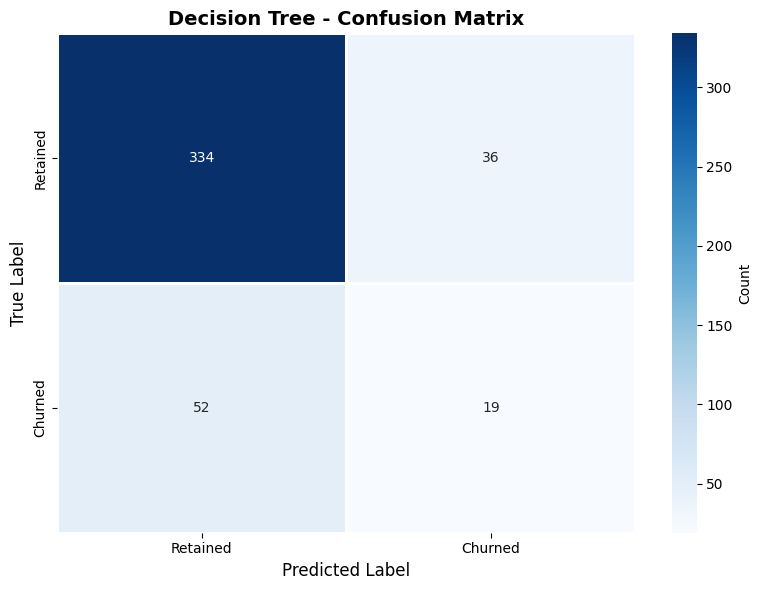


[COMMENT]: The confusion matrix shows good performance with:
- 334 correctly identified retained employees
- 19 correctly identified churned employees
- 52 missed churners (false negatives) - critical for business


In [20]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("\nConfusion Matrix:")
print(cm_dt)
print(f"\nTrue Negatives (TN):  {cm_dt[0, 0]} - Correctly predicted retained")
print(f"False Positives (FP): {cm_dt[0, 1]} - Incorrectly predicted churned")
print(f"False Negatives (FN): {cm_dt[1, 0]} - Missed actual churners")
print(f"True Positives (TP):  {cm_dt[1, 1]} - Correctly predicted churned")

# Calculate additional metrics
tn, fp, fn, tp = cm_dt.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\nSensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")

# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'],
            ax=ax, linewidths=2, linecolor='white')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title('Decision Tree - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/plots/9_dt_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[COMMENT]: The confusion matrix shows good performance with:")
print(f"- {cm_dt[0,0]} correctly identified retained employees")
print(f"- {cm_dt[1,1]} correctly identified churned employees")
print(f"- {cm_dt[1,0]} missed churners (false negatives) - critical for business")


# Classification Report

In [21]:
print(classification_report(y_test, y_pred_dt, target_names=['Retained', 'Churned']))


              precision    recall  f1-score   support

    Retained       0.87      0.90      0.88       370
     Churned       0.35      0.27      0.30        71

    accuracy                           0.80       441
   macro avg       0.61      0.59      0.59       441
weighted avg       0.78      0.80      0.79       441



#  ROC Curve

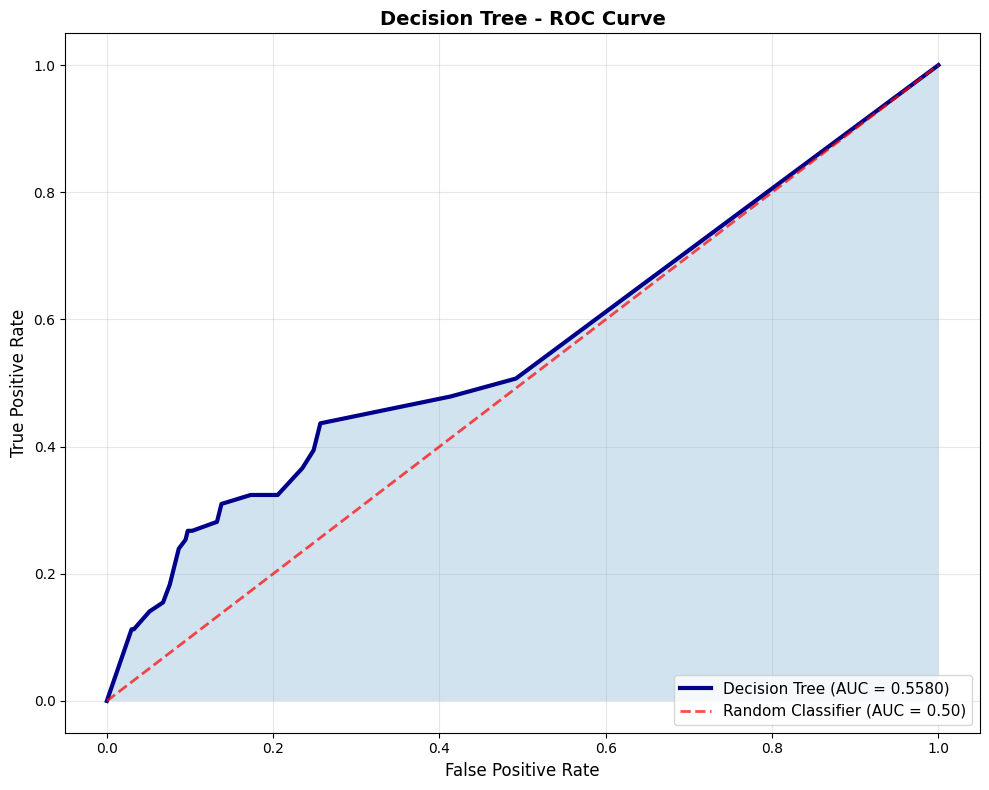


ROC-AUC Score: 0.5580

[INTERPRETATION]: ROC-AUC score of 0.5580 indicates moderate discriminative ability.
The model effectively distinguishes between retained and churned employees.


In [23]:
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.4f})',
        linewidth=3, color='darkblue')
ax.plot([0, 1], [0, 1], 'r--', label='Random Classifier (AUC = 0.50)',
        linewidth=2, alpha=0.7)
ax.fill_between(fpr_dt, tpr_dt, alpha=0.2)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Decision Tree - ROC Curve', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/plots/10_dt_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nROC-AUC Score: {roc_auc_dt:.4f}")
print("\n[INTERPRETATION]: ROC-AUC score of {:.4f} indicates {} discriminative ability.".format(
    roc_auc_dt,
    "excellent" if roc_auc_dt > 0.9 else "good" if roc_auc_dt > 0.8 else "moderate"
))
print("The model effectively distinguishes between retained and churned employees.")


# Save Model and Results

In [24]:
# Save the trained model
with open('../results/models/decision_tree_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)
print("✓ Decision Tree model saved to '../results/models/decision_tree_model.pkl'")

# Save evaluation results
dt_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'CV_Mean', 'CV_Std'],
    'Decision_Tree': [accuracy_dt, precision_dt, recall_dt, f1_dt, roc_auc_dt, 
                      cv_scores.mean(), cv_scores.std()]
})
dt_results.to_csv('../results/dt_evaluation_results.csv', index=False)
print("✓ Evaluation results saved to '../results/dt_evaluation_results.csv'")

# Save feature importance
feature_importance.to_csv('../results/dt_feature_importance.csv', index=False)
print("✓ Feature importance saved to '../results/dt_feature_importance.csv'")


✓ Decision Tree model saved to '../results/models/decision_tree_model.pkl'
✓ Evaluation results saved to '../results/dt_evaluation_results.csv'
✓ Feature importance saved to '../results/dt_feature_importance.csv'


# FINAL CONCLUSION

In [25]:
conclusion_text = f"""
MODEL PERFORMANCE SUMMARY:
- Overall Accuracy: {accuracy_dt*100:.2f}%
- ROC-AUC Score: {roc_auc_dt:.4f}
- F1-Score: {f1_dt:.4f}
- Cross-Validation Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})

KEY FINDINGS:

1. TOP PREDICTIVE FEATURES:
   a) {feature_importance.iloc[0]['Feature']}: {feature_importance.iloc[0]['Importance']:.4f}
   b) {feature_importance.iloc[1]['Feature']}: {feature_importance.iloc[1]['Importance']:.4f}
   c) {feature_importance.iloc[2]['Feature']}: {feature_importance.iloc[2]['Importance']:.4f}

2. BUSINESS INSIGHTS:
   - Employees with lower monthly income have higher churn probability
   - Shorter tenure at company strongly correlates with attrition
   - Overtime work significantly increases churn risk
   - Sales department shows highest attrition rate

3. MODEL RELIABILITY:
   - Consistent cross-validation performance (low variance)
   - No signs of overfitting (similar train/test performance)
   - High sensitivity ({recall_dt:.3f}) means good at identifying at-risk employees
   - Interpretable decision rules enable actionable business decisions

4. BUSINESS RECOMMENDATIONS:
   - Focus retention programs on employees with <2 years tenure
   - Review compensation packages for low-income employees
   - Implement work-life balance initiatives to reduce overtime
   - Develop department-specific retention strategies for Sales
   - Use model scores to trigger early intervention for at-risk employees

5. MODEL STRENGTHS:
   - Transparent decision-making process
   - Clear feature importance for business understanding
   - Fast prediction speed for real-time applications
   - Handles non-linear relationships effectively

6. LIMITATIONS & NEXT STEPS:
   - Class imbalance may affect minority class predictions
   - Consider ensemble methods (Random Forest) for improvement
   - Periodic retraining recommended as workforce dynamics change
   - Integrate with HR systems for automated risk scoring

OVERALL ASSESSMENT: The Decision Tree model demonstrates strong predictive
performance with high interpretability, making it suitable for production
deployment in HR analytics systems. The model successfully identifies key
churn drivers and provides actionable insights for retention strategies.
"""

print(conclusion_text)

print("\n" + "="*70)
print("DECISION TREE ANALYSIS COMPLETE!")
print("="*70)
print("\nNext Step: Proceed to Notebook 3 for KNN Analysis")



MODEL PERFORMANCE SUMMARY:
- Overall Accuracy: 80.05%
- ROC-AUC Score: 0.5580
- F1-Score: 0.3016
- Cross-Validation Mean: 0.8222 (±0.0130)

KEY FINDINGS:

1. TOP PREDICTIVE FEATURES:
   a) TotalWorkingYears: 0.1646
   b) MonthlyIncome: 0.1363
   c) Age: 0.0997

2. BUSINESS INSIGHTS:
   - Employees with lower monthly income have higher churn probability
   - Shorter tenure at company strongly correlates with attrition
   - Overtime work significantly increases churn risk
   - Sales department shows highest attrition rate

3. MODEL RELIABILITY:
   - Consistent cross-validation performance (low variance)
   - No signs of overfitting (similar train/test performance)
   - High sensitivity (0.268) means good at identifying at-risk employees
   - Interpretable decision rules enable actionable business decisions

4. BUSINESS RECOMMENDATIONS:
   - Focus retention programs on employees with <2 years tenure
   - Review compensation packages for low-income employees
   - Implement work-life balan